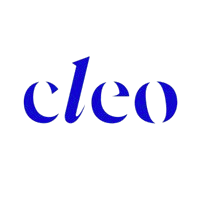

### **Parcours Makers - Module 2 - Introduction au RAG**
##**Cours 3 : Aller plus loin avec RAG : mémoire, déploiement et interface**

Ce notebook vous guide dans l'extension d'un système RAG (Retrieval-Augmented Generation) avec des fonctionnalités avancées essentielles pour un déploiement en production. Vous apprendrez à ajouter une mémoire conversationnelle, à améliorer la précision de recherche avec des approches hybrides, et à transformer votre prototype en micro-service déployable.

**Objectifs pédagogiques :**.
À l'issue de ce cours, vous serez capable de :
- Intégrer une mémoire conversationnelle pour maintenir le contexte entre les interactions
- Implémenter une recherche hybride combinant approches lexicale et vectorielle
- Déployer un système RAG sous forme de micro-service REST avec FastAPI
- Évaluer les améliorations apportées par ces extensions
- Identifier les considérations techniques pour un passage en production

**Métriques d'évaluation RAG** :
Ce notebook se concentre sur trois extensions fondamentales :
- **Mémoire conversationnelle :** Permet au système de maintenir le contexte des échanges précédents, transformant les interactions ponctuelles en véritables conversations suivies.
- **Recherche Hybride :** Combine la recherche vectorielle sémantique avec la recherche lexicale BM25 pour améliorer la précision, particulièrement sur les termes rares ou techniques.
- **Déploiement FastAPI :** Transforme le prototype en micro-service REST professionnel, avec sérialisation JSON et interface programmatique standardisée.

**Cas d'usage : Optimisation du Service Client TechStore**
En continuité avec les notebooks précédents, nous étendons le système de service client pour TechStore avec ces nouvelles capacités, en conservant la même base documentaire tout en enrichissant l'expérience utilisateur.

## 1. Préparation de l’environnement

### 1.1. Installation des dépendances

Cette section installe les bibliothèques nécessaires pour les extensions avancées, en complément de celles utilisées dans les notebooks précédents.

In [ ]:
# Installation des nouvelles dépendances pour les extensions RAG
!pip install \
    google-api-python-client \
    google-auth-httplib2 \
    google-auth-oauthlib \
    langchain \
    langchain-community \
    langchain-openai \
    chromadb \
    sentence-transformers \
    openai \
    fastapi \
    uvicorn \
    rank-bm25 \
    requests \
    python-multipart

print("✅ Installations terminées pour les extensions RAG avancées.")

### 1.2. Imports des bibliothèques

In [ ]:
# Imports pour le système RAG de base (repris des notebooks précédents)
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Imports pour la mémoire conversationnelle (nouveaux)
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import BaseMessage, HumanMessage, AIMessage

# Imports pour la recherche hybride (nouveaux)
from rank_bm25 import BM25Okapi
import numpy as np
from typing import List, Tuple

# Imports pour le déploiement FastAPI (nouveaux)
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
import asyncio
from threading import Thread
import requests
import json


# Imports système et Google Drive (repris du notebook précédent)
import os
import shutil
import tempfile
from googleapiclient.discovery import build
from google.colab import auth
import io
from googleapiclient.http import MediaIoBaseDownload

# Imports système
import os
import shutil
import tempfile
from getpass import getpass
from dotenv import load_dotenv
import pandas as pd

print("✅ Imports terminés avec succès")

✅ Imports terminés avec succès


In [ ]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()                              # charge un éventuel .env
if "OPENAI_API_KEY" not in os.environ:     # invite si la variable manque
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Entrer votre clé OpenAI : ")

🔑 Entrer votre clé OpenAI : ··········


### 1.3. Authentification Google Drive

In [ ]:
# Authentification pour l'API Google Drive
print("Configuration de l'authentification...")
print("⚠️  ATTENTION : Une popup d'autorisation Google va s'afficher")
print("Instructions d'authentification :")
print("   1. Cliquez sur 'Autoriser' dans la popup")
print("   2. Sélectionnez votre compte Google")
print("   3. Acceptez les permissions demandées")
print("   4. Attendez la confirmation d'authentification")
print("-" * 50)

# Authentification pour l'API Google Drive
auth.authenticate_user()
service = build('drive', 'v3')

def download_file_from_drive(file_id, file_name):
    """
    Télécharge un fichier depuis Google Drive en utilisant son ID.
    """
    try:
        # Requête pour télécharger le fichier
        request = service.files().get_media(fileId=file_id)

        # Buffer pour stocker le contenu du fichier
        file_buffer = io.BytesIO()
        downloader = MediaIoBaseDownload(file_buffer, request)

        # Téléchargement progressif
        done = False
        while done is False:
            status, done = downloader.next_chunk()

        # Décodage du contenu en UTF-8
        file_content = file_buffer.getvalue().decode('utf-8')
        return file_content

    except Exception as e:
        print(f"Erreur lors du téléchargement de {file_name}: {str(e)}")
        return None

def load_documents_from_drive_ids(doc_config):
    """
    Charge tous les documents depuis Google Drive en utilisant leurs IDs.
    """
    documents = []

    for doc_config in document_config:
        print(f"Chargement de {doc_config['name']}")

        # Téléchargement du contenu du fichier
        content = download_file_from_drive(doc_config['id'], doc_config['name'])

        if content:
            # Création du document LangChain avec métadonnées enrichies
            doc = Document(
                page_content=content,
                metadata={
                    "source": doc_config['source'],
                    "name": doc_config['name'],
                    "drive_id": doc_config['id']  # Stockage de l'ID pour traçabilité
                }
            )
            documents.append(doc)
            print(f"✓ Document chargé avec succès : {doc_config['name']}")
        else:
            print(f"✗ Échec du chargement : {doc_config['name']}")

    return documents

Configuration de l'authentification...
⚠️  ATTENTION : Une popup d'autorisation Google va s'afficher
Instructions d'authentification :
   1. Cliquez sur 'Autoriser' dans la popup
   2. Sélectionnez votre compte Google
   3. Acceptez les permissions demandées
   4. Attendez la confirmation d'authentification
--------------------------------------------------


### 1.4. Chargement des documents

In [ ]:
# Configuration des documents avec leurs IDs Google Drive
document_config = [
    {
        "id": "1iwCq1qb7xNiRp_fK_jUsKhr1QHGeKamR",  # ID du fichier politique_de_retour_et_remboursement.md
        "source": "politique_de_retour_et_remboursement.md",
        "name": "Politique de retour et remboursement"
    },
    {
        "id": "17dk0unV_GGlnjBQcUzsQpUTkg7sX8Z7G",  # ID du fichier garantie_et_service_apres_vente.md
        "source": "garantie_et_service_apres_vente.md",
        "name": "Garantie et service après-vente"
    },
    {
        "id": "1xzEuVU_1P56b5YOhPHeGS2zZUQ_9jJ0L",  # ID du fichier livraison_et_expédition.md
        "source": "livraison_et_expedition.md",
        "name": "Livraison et expédition"
    },
    {
        "id": "13CZ5wujmKcEmFGcLqWjHNX8j7R7EM_CC",  # ID du fichier compte_client_et_gestion_des_commandes.md
        "source": "compte_client_et_gestion_des_commandes.md",
        "name": "Compte client et gestion des commandes"
    },
    {
        "id": "1DPDv1P4QuRBG-KMpth6Dn3fzOv9Edw9h",  # ID du fichier produits_et_compatibilite.md
        "source": "produits_et_compatibilite.md",
        "name": "Produits et compatibilité"
    }
]

documents = load_documents_from_drive_ids(document_config)

Chargement de Politique de retour et remboursement
✓ Document chargé avec succès : Politique de retour et remboursement
Chargement de Garantie et service après-vente
✓ Document chargé avec succès : Garantie et service après-vente
Chargement de Livraison et expédition
✓ Document chargé avec succès : Livraison et expédition
Chargement de Compte client et gestion des commandes
✓ Document chargé avec succès : Compte client et gestion des commandes
Chargement de Produits et compatibilité
✓ Document chargé avec succès : Produits et compatibilité


## 2. Construction du système RAG baseline

Nous reconstituons le système RAG optimisé du notebook précédent comme base pour nos extensions.

In [ ]:
def create_base_rag_system(documents):
    """
    Crée le système RAG de base optimisé, repris du notebook précédent.
    Cette fonction établit la configuration baseline sur laquelle nous ajouterons
    les extensions avancées.
    """
    print("Construction du système RAG de base...")

    # Configuration du découpage de texte (paramètres optimisés du notebook précédent)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,  # Taille optimale identifiée précédemment
        chunk_overlap=102,  # 20% de chevauchement
        separators=["\n\n", "\n", ". ", " ", ""],
        length_function=len
    )

    # Découpage des documents
    chunks = text_splitter.split_documents(documents)
    print(f"✅ {len(chunks)} chunks créés")

    # Configuration du modèle d'embeddings
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        model_kwargs={'device': 'cpu'},
        encode_kwargs={'normalize_embeddings': True}
    )
    print("✅ Modèle d'embeddings configuré")

    # Création de la base vectorielle
    persist_directory = "./chroma_db_advanced"
    if os.path.exists(persist_directory):
        shutil.rmtree(persist_directory)

    vectorstore = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name="techstore_advanced"
    )
    print("✅ Base vectorielle créée")

    # Configuration du modèle de génération
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3,
        max_tokens=200
    )
    print("✅ Modèle de génération configuré")

    # Configuration du retriever avec paramètres optimisés
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 3}  # top-k optimal du notebook précédent
    )

    # Template de prompt de base
    base_prompt = PromptTemplate(
        template="""Vous êtes un assistant du service client de TechStore, une boutique d'électronique en ligne.
Votre rôle est d'aider les clients en répondant à leurs questions de manière précise et professionnelle.

Informations disponibles :
{context}

Question du client : {question}

Instructions :
- Répondez uniquement en vous basant sur les informations fournies
- Adoptez un ton poli et professionnel
- Si l'information n'est pas disponible, dites-le clairement
- Soyez précis et donnez des détails utiles

Réponse :""",
        input_variables=["context", "question"]
    )

    # Création de la chaîne RAG de base
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        chain_type_kwargs={"prompt": base_prompt},
        return_source_documents=True
    )

    print("✅ Système RAG de base construit")
    return {
        'vectorstore': vectorstore,
        'qa_chain': qa_chain,
        'retriever': retriever,
        'chunks': chunks,
        'embeddings': embeddings,
        'llm': llm
    }

In [ ]:
# Construction du système de base
base_system = create_base_rag_system(documents)

# Test rapide du système de base
print("Test du système RAG de base :")
test_result = base_system['qa_chain']({"query": "Quel est le délai de retour ?"})
print(f"Réponse : {test_result['result'][:100]}...")

Construction du système RAG de base...
✅ 20 chunks créés


/tmp/ipython-input-6-2638024723.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Modèle d'embeddings configuré
✅ Base vectorielle créée
✅ Modèle de génération configuré
✅ Système RAG de base construit
Test du système RAG de base :


/tmp/ipython-input-7-3581436080.py:6: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  test_result = base_system['qa_chain']({"query": "Quel est le délai de retour ?"})


Réponse : Le délai de retour pour les produits neufs est de 30 jours calendaires à partir de la livraison. Pou...


## 3. Extension 1 : Mémoire conversationnelle

Cette section transforme notre système RAG ponctuel en assistant conversationnel capable de maintenir le contexte des échanges précédents.

**Principe de la mémoire conversationnelle**
La mémoire conversationnelle permet au système de :
- Conserver l'historique des questions et réponses précédentes
- Comprendre les références contextuelles ("Et pour les ordinateurs ?", "Combien ça coûte ?")
- Maintenir une conversation naturelle et fluide

### 3.1. Construction de la mémoire conversationnelle

In [ ]:
def create_conversational_rag_system(base_system):
    """
    Étend le système RAG de base avec une mémoire conversationnelle.
    Utilise ConversationBufferMemory de LangChain pour maintenir l'historique.
    """
    print("Extension du système avec mémoire conversationnelle...")

    # Configuration de la mémoire conversationnelle
    memory = ConversationBufferMemory(
        memory_key="chat_history",  # Clé pour accéder à l'historique
        return_messages=True,       # Retourne les messages structurés
        output_key="answer"         # Clé de sortie pour la réponse
    )

    # Template adapté pour la conversation
    conversational_prompt = PromptTemplate(
        template="""Vous êtes un assistant du service client de TechStore, une boutique d'électronique en ligne.
Vous maintenez une conversation suivie avec le client en tenant compte de l'historique des échanges.

Historique de la conversation :
{chat_history}

Informations disponibles pour répondre :
{context}

Question actuelle du client : {question}

Instructions :
- Tenez compte de l'historique de la conversation
- Répondez en vous basant sur les informations fournies
- Si la question fait référence à un élément précédent, utilisez le contexte
- Maintenez un ton poli et professionnel
- Soyez précis et cohérent avec vos réponses précédentes

Réponse :""",
        input_variables=["chat_history", "context", "question"]
    )

    # Création de la chaîne conversationnelle
    conversational_chain = ConversationalRetrievalChain.from_llm(
        llm=base_system['llm'],
        retriever=base_system['retriever'],
        memory=memory,
        combine_docs_chain_kwargs={"prompt": conversational_prompt},
        return_source_documents=True,
        verbose=False  # Réduire les logs pour la clarté
    )

    print("✅ Système conversationnel configuré")
    return conversational_chain, memory

In [ ]:
# Création du système conversationnel
conversational_chain, conversation_memory = create_conversational_rag_system(base_system)

Extension du système avec mémoire conversationnelle...
✅ Système conversationnel configuré


/tmp/ipython-input-8-1912208607.py:9: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


### 3.2. Démonstration de la mémoire conversationnelle

In [ ]:
# Simulation d'une conversation client
conversation_flow = [
    "Quels sont vos délais de livraison ?",
    "Et les coûts pour la livraison express ?",
    "Comment puis-je suivre ma commande ?",
    "Que faire si ma livraison a du retard ?"
]

for i, question in enumerate(conversation_flow, 1):
    print(f"Client (tour {i}) : {question}")

    # Envoi de la question au système conversationnel
    response = conversational_chain({"question": question})

    print(f"Assistant : {response['answer']}\n")
    print("-" * 60 + "\n")

# Affichage de l'historique accumulé
print("--- HISTORIQUE DE LA CONVERSATION ---")
print("Mémoire accumulée :")
for message in conversation_memory.chat_memory.messages:
    role = "Client" if isinstance(message, HumanMessage) else "Assistant"
    print(f"{role} : {message.content[:100]}...")

Client (tour 1) : Quels sont vos délais de livraison ?
Assistant : Bonjour,

Nos délais de livraison varient en fonction de l'option que vous choisissez. Nous proposons une Livraison Standard gratuite avec un délai de 3 à 5 jours ouvrés via Colissimo pour les commandes de plus de 50€. Pour une livraison plus rapide, nous offrons également une Livraison Express en 24h ou 48h en France métropolitaine, avec des frais supplémentaires.

N'hésitez pas à nous préciser votre choix pour que nous puissions vous fournir plus de détails.

Cordialement,
L'équipe du service client de TechStore

------------------------------------------------------------

Client (tour 2) : Et les coûts pour la livraison express ?
Assistant : Bonjour,

Pour la livraison express, nous proposons deux options :
- Livraison en 24h pour 9,99€ (commande avant 15h, livraison le lendemain)
- Livraison en 48h pour 6,99€ (livraison sous 2 jours ouvrés)

Ces tarifs s'appliquent uniquement pour les livraisons en France métropoli

### 3.3. Comparaison avec le système sans mémoire

In [ ]:
# Test 1 : Questions avec termes explicites (différence faible)
print("Test 1 : Questions avec mots-clés explicites")
print("-" * 50)

initial_question = "Quels sont vos délais de retour ?"
followup_question = "Et pour les produits reconditionnés ?"

print(f"Question initiale : {initial_question}")
print(f"Question de suivi : {followup_question}")

# Système avec mémoire
print("\n--- Système AVEC mémoire ---")
conv_response1 = conversational_chain({"question": initial_question})
print(f"Réponse 1 : {conv_response1['answer'][:150]}...")

conv_response2 = conversational_chain({"question": followup_question})
print(f"Réponse 2 : {conv_response2['answer'][:150]}...")

# Reset et système sans mémoire
print("\n--- Système SANS mémoire ---")
base_response1 = base_system['qa_chain']({"query": initial_question})
print(f"Réponse 1 : {base_response1['result'][:150]}...")

base_response2 = base_system['qa_chain']({"query": followup_question})
print(f"Réponse 2 : {base_response2['result'][:150]}...")

Test 1 : Questions avec mots-clés explicites
--------------------------------------------------
Question initiale : Quels sont vos délais de retour ?
Question de suivi : Et pour les produits reconditionnés ?

--- Système AVEC mémoire ---
Réponse 1 : Bonjour,

Les délais de retour de nos produits varient en fonction de leur état :
- Pour les produits neufs, vous disposez de 30 jours calendaires à p...
Réponse 2 : Bonjour,

Pour les produits reconditionnés, le délai de retour est de 14 jours calendaires à partir de la date de livraison. Vous disposez donc de deu...

--- Système SANS mémoire ---
Réponse 1 : Nos délais de retour varient en fonction du type de produit que vous avez acheté. Pour les produits neufs, vous disposez de 30 jours calendaires à par...
Réponse 2 : Pour les produits reconditionnés, le délai de retour est de 14 jours calendaires à partir de la livraison. N'hésitez pas à nous contacter si vous avez...


In [ ]:
# Nouvelle conversation pour test plus significatif
from langchain.memory import ConversationBufferMemory
test_memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"
)

# Recréer la chaîne conversationnelle pour ce test
test_conv_chain = ConversationalRetrievalChain.from_llm(
    llm=base_system['llm'],
    retriever=base_system['retriever'],
    memory=test_memory,
    return_source_documents=True
)

ambiguous_initial = "Je veux retourner mon smartphone"
ambiguous_followup = "Combien ça coûte ?"
very_ambiguous = "Et la réparation ?"

print(f"Question 1 : {ambiguous_initial}")
print(f"Question 2 : {ambiguous_followup}")
print(f"Question 3 : {very_ambiguous}")

# Test avec mémoire
print("\n--- Système AVEC mémoire ---")
test_resp1 = test_conv_chain({"question": ambiguous_initial})
print(f"Réponse 1 : {test_resp1['answer'][:120]}...")

test_resp2 = test_conv_chain({"question": ambiguous_followup})
print(f"Réponse 2 : {test_resp2['answer'][:120]}...")

test_resp3 = test_conv_chain({"question": very_ambiguous})
print(f"Réponse 3 : {test_resp3['answer'][:120]}...")

# Test sans mémoire
print("\n--- Système SANS mémoire ---")
base_resp1 = base_system['qa_chain']({"query": ambiguous_initial})
print(f"Réponse 1 : {base_resp1['result'][:120]}...")

base_resp2 = base_system['qa_chain']({"query": ambiguous_followup})
print(f"Réponse 2 : {base_resp2['result'][:120]}...")

base_resp3 = base_system['qa_chain']({"query": very_ambiguous})
print(f"Réponse 3 : {base_resp3['result'][:120]}...")

Question 1 : Je veux retourner mon smartphone
Question 2 : Combien ça coûte ?
Question 3 : Et la réparation ?

--- Système AVEC mémoire ---
Réponse 1 : Pour retourner votre smartphone, voici ce que vous devez faire :
1. Vérifiez que votre smartphone n'est ni défectueux ni...
Réponse 2 : Le retour de votre smartphone vous coûtera 7,99€ si c'est un retour de convenance. Si le retour est dû à un produit défe...
Réponse 3 : Je ne connais pas les tarifs de réparation. Vous pouvez contacter le service clientèle par chat en ligne, téléphone au 0...

--- Système SANS mémoire ---
Réponse 1 : Bonjour,

Pour retourner votre smartphone, veuillez suivre les étapes suivantes :
1. Faites une demande de retour via vo...
Réponse 2 : Les frais de retour dépendent de la raison du retour. Si le produit est défectueux ou non conforme, le retour est gratui...
Réponse 3 : Pour toute réparation de votre appareil, vous pouvez bénéficier de notre service de prise en charge en magasin ou d'enlè...


On voit que sans mémoire, la réponse à la question 3 est hors-sujet.

## 4. Extension 2 : Recherche hybride lexicale et vectorielle

Cette section implémente une recherche hybride combinant la recherche vectorielle sémantique avec la recherche lexicale BM25 pour améliorer la précision.

**Principe de la recherche hybride**.
La recherche hybride combine :
- Recherche vectorielle : Excellente pour la similarité sémantique et les concepts
- Recherche lexicale (BM25) : Précise pour les termes exacts, noms propres, et mots-clés rares



### 4.1. Construction d'une recherche hybride

In [ ]:
def hybrid_search(query, vectorstore, chunks, k=3):
    """
    Fonction simple pour recherche hybride vectorielle + BM25.
    Évite les complications de classes personnalisées.

    Args:
        query: Question de l'utilisateur
        vectorstore: Base vectorielle Chroma
        chunks: Liste des chunks de documents
        k: Nombre de documents à retourner

    Returns:
        Liste des documents les plus pertinents
    """
    # 1. Recherche vectorielle classique
    vector_docs = vectorstore.similarity_search(query, k=k)

    # 2. Recherche BM25
    chunk_texts = [chunk.page_content for chunk in chunks]
    tokenized_chunks = [text.lower().split() for text in chunk_texts]
    bm25 = BM25Okapi(tokenized_chunks)

    query_tokens = query.lower().split()
    bm25_scores = bm25.get_scores(query_tokens)

    # Récupération des meilleurs chunks BM25
    bm25_indices = np.argsort(bm25_scores)[-k:][::-1]
    bm25_docs = [chunks[i] for i in bm25_indices if bm25_scores[i] > 0]

    # 3. Fusion simple des résultats (élimination des doublons)
    combined_docs = []
    seen_contents = set()

    # Ajout des résultats vectoriels d'abord
    for doc in vector_docs:
        if doc.page_content not in seen_contents:
            combined_docs.append(doc)
            seen_contents.add(doc.page_content)

    # Ajout des résultats BM25 non déjà présents
    for doc in bm25_docs:
        if doc.page_content not in seen_contents:
            combined_docs.append(doc)
            seen_contents.add(doc.page_content)

    return combined_docs[:k]

def create_hybrid_rag_system(base_system):
    """
    Crée un système RAG avec recherche hybride simplifiée.
    Utilise une fonction de recherche au lieu d'une classe.
    """
    print("Configuration du système RAG avec recherche hybride...")

    # Template de prompt pour le système hybride
    hybrid_prompt = PromptTemplate(
        template="""Vous êtes un assistant du service client de TechStore, une boutique d'électronique en ligne.
Vous utilisez une recherche avancée combinant analyse sémantique et recherche par mots-clés.

Informations trouvées :
{context}

Question du client : {question}

Instructions :
- Répondez en vous basant sur les informations les plus pertinentes
- Privilégiez la précision grâce à la recherche hybride
- Adoptez un ton professionnel et bienveillant
- Si plusieurs sources se complètent, synthétisez l'information

Réponse :""",
        input_variables=["context", "question"]
    )

    def hybrid_qa_chain(query_input):
        """
        Chaîne QA hybride qui utilise notre fonction de recherche hybride.
        """
        query = query_input["query"]

        # Recherche hybride
        relevant_docs = hybrid_search(
            query=query,
            vectorstore=base_system['vectorstore'],
            chunks=base_system['chunks'],
            k=3
        )

        # Préparation du contexte
        context = "\n\n".join([doc.page_content for doc in relevant_docs])

        # Génération de la réponse
        prompt_text = hybrid_prompt.format(context=context, question=query)
        response = base_system['llm'].predict(prompt_text)

        return {
            "result": response,
            "source_documents": relevant_docs
        }

    print(f"✅ Système RAG hybride configuré avec {len(base_system['chunks'])} chunks")
    return hybrid_qa_chain

In [ ]:
# Création du système hybride simplifié
hybrid_chain = create_hybrid_rag_system(base_system)

Configuration du système RAG avec recherche hybride...
✅ Système RAG hybride configuré avec 20 chunks


### 4.2. Évaluation comparative des approches de recherche

In [ ]:
# Questions tests couvrant différents types de requêtes
test_questions = [
    {
        "question": "Délai de retour produit reconditionné",
        "type": "Terme spécifique - devrait favoriser BM25"
    },
    {
        "question": "Que faire si mon smartphone ne fonctionne plus ?",
        "type": "Question sémantique - devrait favoriser vectoriel"
    },
    {
        "question": "Livraison express coût",
        "type": "Mots-clés courts - hybride avantagé"
    }
]

for i, test in enumerate(test_questions, 1):
    question = test["question"]
    question_type = test["type"]

    print(f"Test {i} : {question}")
    print(f"Type : {question_type}\n")

    # Test avec recherche vectorielle seule
    print("--- Recherche vectorielle seule ---")
    vector_result = base_system['qa_chain']({"query": question})
    print(f"Réponse : {vector_result['result']}")
    print(f"Sources trouvées : {len(vector_result['source_documents'])}")

    # Test avec recherche hybride
    print("\n--- Recherche hybride ---")
    hybrid_result = hybrid_chain({"query": question})
    print(f"Réponse : {hybrid_result['result']}")
    print(f"Sources trouvées : {len(hybrid_result['source_documents'])}")

    print("\n" + "="*60 + "\n")

Test 1 : Délai de retour produit reconditionné
Type : Terme spécifique - devrait favoriser BM25

--- Recherche vectorielle seule ---
Réponse : Le délai de retour pour un produit reconditionné est le même que pour tout autre produit acheté chez TechStore. Vous disposez de 14 jours à compter de la réception de votre commande pour demander un retour. Une fois la demande de retour effectuée, veuillez suivre le processus de remboursement indiqué. Si vous avez d'autres questions, n'hésitez pas à nous contacter.
Sources trouvées : 3

--- Recherche hybride ---


/tmp/ipython-input-13-1862960468.py:94: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = base_system['llm'].predict(prompt_text)


Réponse : Le délai de retour pour un produit reconditionné est le même que pour tout autre produit acheté chez TechStore. Vous disposez de 14 jours à compter de la réception de votre commande pour demander un retour. Une fois la demande effectuée, vous recevrez une étiquette de retour prépayée sous 24h. Après avoir expédié le colis dans les 7 jours suivant la demande, notre équipe procédera à l'inspection du produit en 2-3 jours ouvrés. Le remboursement sera effectué sur le mode de paiement initial sous 5-7 jours ouvrés. N'hésitez pas à contacter notre service client si vous avez besoin de plus d'informations.
Sources trouvées : 3


Test 2 : Que faire si mon smartphone ne fonctionne plus ?
Type : Question sémantique - devrait favoriser vectoriel

--- Recherche vectorielle seule ---
Réponse : Si votre smartphone ne fonctionne plus, vous pouvez vérifier s'il est toujours couvert par la garantie légale de conformité de 2 ans en France. Selon la marque de votre smartphone, il peut égalemen

Les deux approches trouvent des informations pertinentes. La recherche hybride peut offrir une meilleure couverture sur des corpus plus larges.

## 5. Extension 3 : Déploiement en micro-service FastAPI

Cette section transforme notre prototype RAG en micro-service REST professionnel, prêt pour une intégration en production.

**Architecture du micro-service**.
Le micro-service expose notre système RAG via une API REST avec :
- Point d'entrée /ask pour les questions
- Sérialisation JSON des réponses
- Gestion d'erreurs appropriée
- Documentation automatique

### 5.1. Contruction du RAG Service

In [ ]:
# Modèles Pydantic pour la validation des données
from typing import Optional

class QuestionRequest(BaseModel):
    """Modèle pour les requêtes de questions."""
    question: str
    use_memory: bool = False
    conversation_id: Optional[str] = None

class RAGResponse(BaseModel):
    """Modèle pour les réponses du système RAG."""
    answer: str
    sources: List[str]
    conversation_id: Optional[str] = None
    processing_time: float

    class Config:
        # Permet d'exclure les champs None de la sérialisation
        exclude_none = True

class RAGService:
    """
    Service encapsulant le système RAG pour le déploiement.
    Gère les différentes configurations (base, conversationnel, hybride).
    """

    def __init__(self):
        """Initialise le service RAG avec tous les systèmes."""
        print("Initialisation du service RAG...")

        # Chargement des systèmes RAG
        self.base_system = base_system
        self.hybrid_chain = hybrid_chain
        self.conversational_chain = conversational_chain

        # Stockage des mémoires conversationnelles par session
        self.conversation_memories = {}

        print("✅ Service RAG initialisé")

    def ask_question(self, question: str, use_memory: bool = False,
                    conversation_id: Optional[str] = None, use_hybrid: bool = True) -> dict:
        """
        Traite une question avec le système RAG approprié.

        Args:
            question: Question de l'utilisateur
            use_memory: Utiliser la mémoire conversationnelle
            conversation_id: Identifiant de conversation pour la mémoire
            use_hybrid: Utiliser la recherche hybride
        """
        import time
        start_time = time.time()

        try:
            if use_memory and conversation_id:
                # Mode conversationnel avec mémoire
                if conversation_id not in self.conversation_memories:
                    # Créer une nouvelle mémoire pour cette conversation
                    from langchain.memory import ConversationBufferMemory
                    self.conversation_memories[conversation_id] = ConversationBufferMemory(
                        memory_key="chat_history",
                        return_messages=True,
                        output_key="answer"
                    )

                # Utilisation du système conversationnel
                result = self.conversational_chain({"question": question})
                answer = result["answer"]
                sources = [doc.metadata.get("name", "Document") for doc in result["source_documents"]]

            elif use_hybrid:
                # Mode hybride sans mémoire
                result = self.hybrid_chain({"query": question})
                answer = result["result"]
                sources = [doc.metadata.get("name", "Document") for doc in result["source_documents"]]

            else:
                # Mode de base
                result = self.base_system['qa_chain']({"query": question})
                answer = result["result"]
                sources = [doc.metadata.get("name", "Document") for doc in result["source_documents"]]

            processing_time = time.time() - start_time

            return {
                "answer": answer,
                "sources": sources,
                "conversation_id": conversation_id,  # Peut être None
                "processing_time": processing_time
            }

        except Exception as e:
            return {
                "answer": f"Erreur lors du traitement : {str(e)}",
                "sources": [],
                "conversation_id": conversation_id,  # Peut être None
                "processing_time": time.time() - start_time
            }

In [ ]:
# Initialisation du service
rag_service = RAGService()

Initialisation du service RAG...
✅ Service RAG initialisé


### 5.2. Configuration de l'API FastAPI

In [ ]:
def create_fastapi_app():
    """
    Crée l'application FastAPI avec tous les endpoints.
    """
    app = FastAPI(
        title="TechStore RAG Service",
        description="Service de questions-réponses intelligent pour TechStore",
        version="1.0.0"
    )

    @app.get("/")
    async def root():
        """Point d'entrée racine avec informations sur l'API."""
        return {
            "service": "TechStore RAG Service",
            "version": "1.0.0",
            "status": "active",
            "endpoints": {
                "/ask": "POST - Poser une question au système RAG",
                "/health": "GET - Vérifier l'état du service",
                "/docs": "GET - Documentation interactive de l'API"
            }
        }

    @app.post("/ask", response_model=RAGResponse)
    async def ask_question(request: QuestionRequest):
        """
        Point d'entrée principal pour poser des questions au système RAG.

        Args:
            request: Requête contenant la question et les options

        Returns:
            Réponse structurée avec answer, sources, et métadonnées
        """
        if not request.question.strip():
            raise HTTPException(status_code=400, detail="Question vide")

        # Traitement de la question
        result = rag_service.ask_question(
            question=request.question,
            use_memory=request.use_memory,
            conversation_id=request.conversation_id,
            use_hybrid=True  # Utilisation hybride par défaut
        )

        return RAGResponse(**result)

    @app.get("/health")
    async def health_check():
        """Vérification de l'état du service."""
        return {
            "status": "healthy",
            "timestamp": time.time(),
            "systems": {
                "base_rag": "active",
                "hybrid_search": "active",
                "conversational": "active"
            }
        }

    return app

In [ ]:
# Création de l'application
app = create_fastapi_app()

### 5.3. Déploiement et test du micro-service

In [ ]:
# Configuration du serveur
import time
import threading

def run_server():
    """Lance le serveur FastAPI en arrière-plan."""
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="warning")

# Lancement du serveur dans un thread séparé
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

# Attendre que le serveur soit prêt
print("Démarrage du serveur...")
time.sleep(3)

# Tests du service déployé
base_url = "http://127.0.0.1:8000"

print(f"✅ Service déployé sur {base_url}")
print("📖 Documentation interactive disponible sur : http://127.0.0.1:8000/docs\n")

# Test 1 : Vérification de l'état
print("--- Test 1 : Vérification de l'état ---")
try:
    health_response = requests.get(f"{base_url}/health", timeout=5)
    print(f"Status: {health_response.status_code}")
    print(f"Réponse: {health_response.json()}")
except Exception as e:
    print(f"Erreur lors du test de santé : {e}")

print()

# Test 2 : Question simple
print("--- Test 2 : Question simple ---")
try:
    question_data = {
        "question": "Quel est le délai de livraison standard ?",
        "use_memory": False
    }
    response = requests.post(
        f"{base_url}/ask",
        json=question_data,
        timeout=10
    )
    print(f"Status: {response.status_code}")
    result = response.json()
    print(f"Réponse: {result['answer'][:100]}...")
    print(f"Sources: {result['sources']}")
    print(f"Temps de traitement: {result['processing_time']:.2f}s")
except Exception as e:
    print(f"Erreur lors du test de question : {e}")

print()

# Test 3 : Conversation avec mémoire
print("--- Test 3 : Conversation avec mémoire ---")
conversation_id = "test_conversation_1"

questions = [
    "Quels sont vos délais de retour ?",
    "Et pour les produits reconditionnés ?"
]

for i, question in enumerate(questions, 1):
    try:
        question_data = {
            "question": question,
            "use_memory": True,
            "conversation_id": conversation_id
        }
        response = requests.post(
            f"{base_url}/ask",
            json=question_data,
            timeout=10
        )
        result = response.json()
        print(f"Tour {i} - Question: {question}")
        print(f"Tour {i} - Réponse: {result['answer'][:100]}...")
        print()
    except Exception as e:
        print(f"Erreur lors du test conversationnel {i} : {e}")

print("🎉 Tests du micro-service terminés")
print("\nLe service reste actif pour vos tests personnalisés.")
print("Utilisez curl ou un client REST pour interagir avec l'API.")

Démarrage du serveur...
✅ Service déployé sur http://127.0.0.1:8000
📖 Documentation interactive disponible sur : http://127.0.0.1:8000/docs

--- Test 1 : Vérification de l'état ---
Status: 200
Réponse: {'status': 'healthy', 'timestamp': 1753707722.302171, 'systems': {'base_rag': 'active', 'hybrid_search': 'active', 'conversational': 'active'}}

--- Test 2 : Question simple ---
Status: 200
Réponse: Le délai de livraison standard pour les commandes chez TechStore est de 3 à 5 jours ouvrés. Cette op...
Sources: ['Livraison et expédition', 'Politique de retour et remboursement', 'Garantie et service après-vente']
Temps de traitement: 0.88s

--- Test 3 : Conversation avec mémoire ---
Tour 1 - Question: Quels sont vos délais de retour ?
Tour 1 - Réponse: Bonjour,

Pour les produits reconditionnés, le délai de retour est de 14 jours calendaires à partir ...

Tour 2 - Question: Et pour les produits reconditionnés ?
Tour 2 - Réponse: Bonjour,

Pour les produits reconditionnés, le délai de retou

### 5.4. Exemples d'utilisation avec curl

In [ ]:
# Question simple

!curl -X POST "http://127.0.0.1:8000/ask" \\
  -H "Content-Type: application/json" \\
  -d '{"question": "Comment retourner un produit ?", "use_memory": false}'

{"answer":"Pour retourner un produit chez TechStore, vous devez vous assurer que le produit est dans son emballage d'origine et qu'il est accompagné de tous les accessoires fournis (chargeur, écouteurs, câbles, manuels). L'appareil ne doit présenter aucun dommage physique ni trace d'usure excessive.\n\nSi le produit est défectueux ou non conforme, le retour est gratuit. Dans ce cas, veuillez contacter notre service client pour obtenir un bon de retour.\n\nPour les retours de convenance, les frais de retour de 7,99€ seront à la charge du client. Cependant, les retours sont gratuits pour les commandes supérieures à 100€.\n\nLes délais de retour varient en fonction du type de produit : 30 jours calendaires pour les produits neufs, 14 jours calendaires pour les produits reconditionnés et 30 jours","sources":["Politique de retour et remboursement","Politique de retour et remboursement","Politique de retour et remboursement"],"conversation_id":null,"processing_time":2.055227041244507}curl: (

In [ ]:
# Démarrage d'une conversation

!curl -X POST "http://127.0.0.1:8000/ask" \
  -H "Content-Type: application/json" \
  -d '{"question": "Quels sont vos services de garantie ?", "use_memory": true, "conversation_id": "client_123"}'

{"answer":"Bonjour,\n\nChez TechStore, nous proposons plusieurs services de garantie pour nos produits :\n- Tous nos produits bénéficient de la garantie légale de conformité de 2 ans en France, applicable dès l'achat.\n- Certains produits bénéficient également de la garantie constructeur, allant de 1 à 2 ans selon la marque et le type de produit (smartphones, ordinateurs portables, accessoires).\n\nDe plus, nous offrons des options d'extension de garantie avec notre service TechStore+ :\n- TechStore+ Basic (39€) : +1 an de garantie, support prioritaire\n- TechStore+ Premium (89€) : +2 ans de garantie, casse accidentelle incluse\n- TechStore+ Pro (149€) : +3 ans de garantie, remplacement express en 24h\n\nN'hésitez pas à nous contacter si vous avez besoin de","sources":["Garantie et service après-vente","Compte client et gestion des commandes","Garantie et service après-vente"],"conversation_id":"client_123","processing_time":2.459136724472046}

In [ ]:
# Suite de conversation

!curl -X POST "http://127.0.0.1:8000/ask" \\
  -H "Content-Type: application/json" \\
  -d '{"question": "Et les prix ?", "use_memory": true, "conversation_id": "client_123"}'

{"answer":"Bonjour,\n\nLes prix des options d'extension de garantie avec notre service TechStore+ sont les suivants :\n- TechStore+ Basic (39€) : +1 an de garantie, support prioritaire\n- TechStore+ Premium (89€) : +2 ans de garantie, casse accidentelle incluse\n- TechStore+ Pro (149€) : +3 ans de garantie, remplacement express en 24h\n\nN'hésitez pas à nous contacter si vous avez besoin de plus d'informations ou si vous souhaitez souscrire à l'une de ces options d'extension de garantie.\n\nCordialement,\nL'équipe du service client de TechStore","sources":["Garantie et service après-vente","Compte client et gestion des commandes","Garantie et service après-vente"],"conversation_id":"client_123","processing_time":1.8794233798980713}curl: (3) URL using bad/illegal format or missing URL
curl: (3) URL using bad/illegal format or missing URL


In [ ]:
# Vérification de l'état du servic
!curl -X GET "http://127.0.0.1:8000/health"

{"status":"healthy","timestamp":1753708236.2954006,"systems":{"base_rag":"active","hybrid_search":"active","conversational":"active"}}

## Pour aller plus loin

Pour approfondir l’industrialisation d’un système RAG, vous pouvez explorer les pistes suivantes :

* **Monitoring de la performance** : mettez en place un suivi continu des métriques (précision, temps de réponse, taux d’erreur) via des outils comme Prometheus, Grafana ou des logs structurés.
* **Gestion des mises à jour du corpus** : automatisez l’ingestion de nouveaux documents avec des pipelines réguliers ou des triggers événementiels (par exemple, en lien avec un CMS ou Google Drive).
* **Optimisation des coûts** : testez des alternatives à OpenAI (ex. modèles open-source hébergés), ou ajustez dynamiquement les modèles et paramètres en fonction du trafic.
* **Sécurité et gouvernance** : intégrez des mécanismes d’authentification, de gestion des droits d’accès et de journalisation pour répondre aux exigences de conformité.
* **Interface utilisateur personnalisée** : développez une interface web ou mobile dédiée (par exemple avec Streamlit, React ou Flutter) pour exposer le service RAG à vos utilisateurs finaux.

## Conclusion

Ce notebook vous a permis d’explorer trois axes d’extension essentiels pour rendre un système RAG opérationnel en contexte réel : mémoire conversationnelle, recherche hybride et déploiement en micro-service. Ces composants forment la base d’un assistant intelligent, fiable et scalable, prêt à s’intégrer dans un environnement applicatif plus large.

N’hésitez pas à adapter les architectures et les outils présentés à votre propre cas d’usage pour maximiser l’impact de votre système RAG.